# Adaptive PDE discretizations on cartesian grids 
## Volume : GPU accelerated methods
## Part : Reproducibility
## Chapter : Flow and geodesics

We compute the geodesic flow and minimal geodesics, on the CPU and GPU, checking for consistency.

## 0. Importing the required libraries

In [1]:
import sys; sys.path.insert(0,"../..")
#from Miscellaneous import TocTools; print(TocTools.displayTOC('Isotropic_Repro','GPU'))

In [2]:
import cupy as cp
import numpy as np
import itertools
from matplotlib import pyplot as plt
np.set_printoptions(edgeitems=30, linewidth=100000, formatter=dict(float=lambda x: "%5.3g" % x))

In [3]:
from agd import HFMUtils
from agd import AutomaticDifferentiation as ad
from agd import Metrics
from agd import FiniteDifferences as fd
import agd.AutomaticDifferentiation.cupy_generic as cugen
norm_infinity = ad.Optimization.norm_infinity
from agd.HFMUtils import RunGPU,RunSmart

In [4]:
def ReloadPackages():
    from Miscellaneous.rreload import rreload
    global HFMUtils,ad,cugen,RunGPU
    HFMUtils,ad,cugen,RunGPU = rreload([HFMUtils,ad,cugen,RunGPU],"../..")    

In [5]:
cp = ad.functional.decorate_module_functions(cp,cugen.set_output_dtype32) # Use float32 and int32 types in place of float64 and int64
plt = ad.functional.decorate_module_functions(plt,cugen.cupy_get_args)
RunSmart = cugen.cupy_get_args(RunSmart,dtype64=True,iterables=(dict,Metrics.Base))

In [6]:
def RunCompare(gpuIn,check=True):
    gpuOut = RunGPU(gpuIn)
    if gpuIn.get('verbosity',1): print("---")
    cpuOut = RunSmart(gpuIn)
    print("Max |gpuValues-cpuValues| : ", norm_infinity(gpuOut['values'].get()-cpuOut['values']))
    cpuTime = cpuOut['FMCPUTime']; gpuTime = gpuOut['solverGPUTime'];
    print(f"Solver time (s). GPU : {gpuTime}, CPU : {cpuTime}. Device acceleration : {cpuTime/gpuTime}")
    assert not check or cp.allclose(gpuOut['values'],cpuOut['values'],atol=1e-6)
    return gpuOut,cpuOut

# 1. Isotropic metrics

In [7]:
n=201
hfmIn = HFMUtils.dictIn({
    'model':'Isotropic2',
    'seeds':[[0.,0.]],
    'exportValues':1,
    'cost':cp.array(1.),
    'exportGeodesicFlow':1,
})
hfmIn.SetRect([[-1,1],[-1,1]],dimx=n+1,sampleBoundary=True)
X = hfmIn.Grid()
hfmIn['tips']=hfmIn.Grid(dims=(4,4)).reshape(2,-1).T

Casting output of function array from float64 to float32


In [8]:
gpuOut = RunGPU(hfmIn)

Setting the kernel traits.
Prepating the domain data (shape,metric,...)
Preparing the values array (setting seeds,...)
Preparing the GPU kernel
Setup and run the eikonal solver
GPU solve took 0.029477834701538086 seconds, in 10 iterations.
Post-Processing


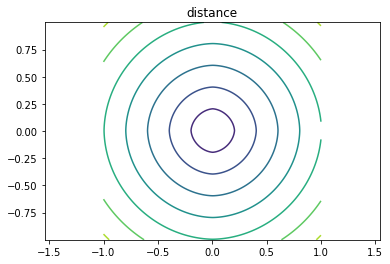

In [9]:
plt.title('distance'); plt.axis('equal')
plt.contour(*X,gpuOut['values']);

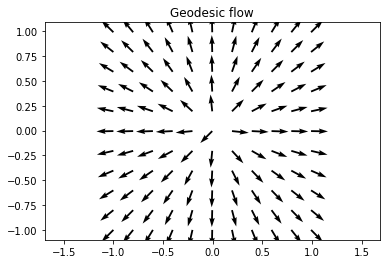

In [10]:
plt.title("Geodesic flow"); plt.axis('equal')
s=20; plt.quiver(*X[:,::s,::s],*gpuOut['flow'][:,::s,::s]);

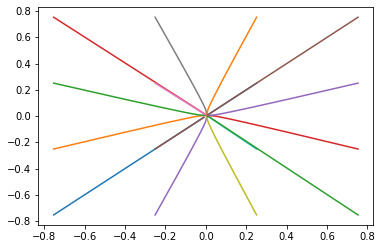

In [11]:
for geo in gpuOut['geodesics']: plt.plot(*geo);

## 2. Riemannian metrics

In [12]:
n=199
hfmIn = HFMUtils.dictIn({
    'model':'Riemann2',
    'seeds':[[0.,0.]],
    'exportValues':1,
    'metric':Metrics.Riemann(cp.array([[1.,1.],[1.,2.]])),
    'exportGeodesicFlow':1,
})
hfmIn.SetRect([[-1,1],[-1,1]],dimx=n+1,sampleBoundary=True)
X = hfmIn.Grid()
hfmIn['tips']=hfmIn.Grid(dims=(4,4)).reshape(2,-1).T

Casting output of function array from float64 to float32


In [13]:
gpuOut = RunGPU(hfmIn)

Setting the kernel traits.
Prepating the domain data (shape,metric,...)
Preparing the values array (setting seeds,...)
Preparing the GPU kernel
Setup and run the eikonal solver
GPU solve took 0.03600049018859863 seconds, in 66 iterations.
Post-Processing


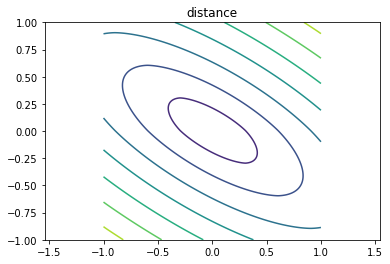

In [14]:
plt.title('distance'); plt.axis('equal')
plt.contour(*X,gpuOut['values']);

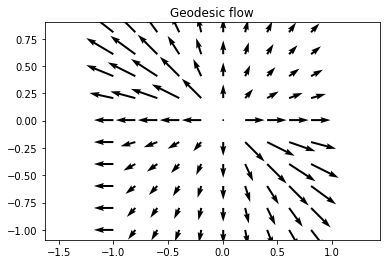

In [15]:
plt.title("Geodesic flow"); plt.axis('equal')
s=20; plt.quiver(*X[:,::s,::s],*gpuOut['flow'][:,::s,::s]);

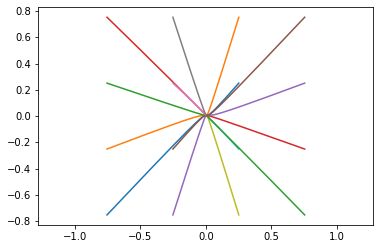

In [16]:
plt.axis('equal')
for geo in gpuOut['geodesics']: plt.plot(*geo);

## 3. Rander metrics

In [17]:
ReloadPackages()

In [18]:
n=201
hfmIn = HFMUtils.dictIn({
    'model':'Rander2', 'metric':Metrics.Rander(cp.eye(2),cp.array([0.,0.5])),
    'seeds':[[0.,0.]],
    'exportValues':1,
    'exportGeodesicFlow':1,
})
hfmIn.SetRect([[-1,1],[-1,1]],dimx=n+1,sampleBoundary=True)
X = hfmIn.Grid()
hfmIn['tips']=hfmIn.Grid(dims=(4,4)).reshape(2,-1).T

Casting output of function eye from float64 to float32
Casting output of function array from float64 to float32


In [19]:
gpuOut = RunGPU(hfmIn)

Setting the kernel traits.
Prepating the domain data (shape,metric,...)
Preparing the values array (setting seeds,...)
Preparing the GPU kernel
Setup and run the eikonal solver
GPU solve took 0.012496232986450195 seconds, in 28 iterations.
Post-Processing


NameError: name 'fd' is not defined

In [ ]:
plt.title('distance'); plt.axis('equal')
plt.contour(*X,gpuOut['values']);

In [ ]:
plt.title("Geodesic flow"); plt.axis('equal')
s=20; plt.quiver(*X[:,::s,::s],*gpuOut['flow'][:,::s,::s]);

In [ ]:
flow=gpuOut['flow'].copy(); flow/=ad.Optimization.norm(flow,axis=0) 
s=20; plt.quiver(*X[:,::s,::s],*flow[:,::s,::s]);

In [ ]:
plt.axis('equal')
for geo in gpuOut['geodesics']: plt.plot(*geo);